# Project 3: Reinforcement Learning (Deep Q Network using Pytorch)
1. We will be using Pytorch for this project. Your are encouraged to go through the "Pytorch 60 minutes blitz" (https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to learn more about Pytorch.
2. Using Google Colab and GPU is recommended for this project

In [ ]:
#Install the following packages
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (600 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 783 kB of 

In [ ]:
# Do NOT change
import os
from pyvirtualdisplay import Display

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output

from IPython import display as ipythondisplay
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
from tqdm import tqdm

# Device contains the details of the compute platform: CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%matplotlib inline

In [ ]:
# Do NOT change
!sudo apt update
!sudo apt install xvfb

display = Display(visible=0, size=(1400, 900))
display.start()

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,370 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net

In [ ]:
# Do NOT change
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### We are going to use the cart pole environment by Gym
Run the below code to see how a randon agent performs in the cart pole environment

In [ ]:
env = gym.make('CartPole-v0')
env = wrap_env(env)

# Reset it, returns the starting frame
frame = env.reset()

is_done = False
while not is_done:
  # Perform a random action, returns the new frame, reward and whether the game is over
  frame, reward, is_done, _ = env.step(env.action_space.sample())

env.close()
show_video()

# Replay Memory

In [ ]:
""" Step 1: Define a Replay Buffer which can store all the experiences of the agent.
    During training, we will sample uniformly from the replay buffer and train our DQN
    The replay buffer is already implemented."""

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.pos  = 0
    
    def push(self, state, action, reward, next_state, done):

        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size):
        
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        samples = [self.buffer[idx] for idx in indices]
        
        batch = np.asarray(list(zip(*samples)))
        states = np.concatenate(batch[0])
        actions = batch[1]
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]
        
        return states, actions, rewards, next_states, dones, indices

    def __len__(self):
        return len(self.buffer)

In [ ]:
""" Step 2.1: Define the Deep Q Network using Pytorch
    Step 2.2: Define the forward pass through the network"""

class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions, device):
        super().__init__()
        
        """Define a fully connected neural network for predicting the Q values, given a state
        The network will have 1 input layer, 1 hidden layer and 1 output layer.
        Use 128 units for the hidden layer"""

        # Step 2.1: Define a Sequential network in Pytorch
        self.layers = nn.Sequential(
          nn.Linear(num_inputs,128), #INPUT LAYER
          nn.ReLU(),
          nn.Linear(128,256), #HIDDEN LAYER
          nn.ReLU(),
          nn.Linear(256,num_actions), #OUTPUT LAYER
        )

        self.num_actions = num_actions
        self.device = device
        
    def forward(self, x):
        # Step 2.2: Forward pass through the Sequential network defined in Step 7 and return the output
        # The output dimension should be batch, num_actions. The input x has batch, num_inputs dimensions
        op = self.layers(x)
        return op
    
    def act(self, state, epsilon):
        state = torch.tensor(state).float().unsqueeze(0).to(self.device)
        if random.random() > epsilon:
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
        else:
            action = random.randrange(self.num_actions)
        return action

In [ ]:
""" Implement the get_target function.
    This function should perform the following:
    Step 3.1: Get the bootstrapped Q values for the next state
    Step 3.2: Calculate the TD target using the Bellman equation"""
def get_target(model, next_state, reward, gamma, done):
    
    model.eval()
    with torch.no_grad():
        # Step 3.1: Get the bootstrapped Q values for the next state
        next_q_values = model(next_state)
        next_q_value = next_q_values.max(1)[0]
        # Step 3.2: Calculate and return the TD target using the Bellman equation
        expected_q_value = reward+gamma*next_q_value*(1-done)

    return expected_q_value

In [ ]:
""" Step 4.1: Sample a batch of examples from the replay buffer
    Step 4.2: Get the predicted Q values of the sampled state by forward pass
            through the DQN
    Step 4.3: Gather only the Q values that correspond to the actions sampled 
            from the replay buffer  
    Step 4.4: Get the target Q values of the sampled state by using the Bellamn 
            Equation. The Q value of next states are estimated by a forward pass 
            through the target network
    Step 4.5: Calculate the Mean Squared Error loss between the predicted Q value 
            and target Q value by using the appropriate loss function in Pytorch.
    Step 4.6: Back propagate the losses and update the model weights
"""
def compute_td_loss(batch_size, device, dqn_model, target_model):

    # Step 4.1: Sample a batch of examples from the replay buffer
    state, action, reward, next_state, done, indices = replay_buffer.sample(batch_size) 

    state = torch.tensor(state.astype('float') ).float().to(device) #batch, n
    next_state = torch.tensor(next_state.astype('float') ).float().to(device)#batch, n
    action = torch.tensor(action.astype('float') ).long().to(device)#batch
    reward = torch.tensor(reward.astype('float') ).float().to(device)#batch
    done = torch.tensor(done.astype('float') ).float().to(device)#batch
    
    dqn_model.train()
    # Step 4.2: Get the predicted Q values of the sampled state by forward pass through the DQN
    q_values = dqn_model.forward(state)
    # Step 4.3: Gather only the Q values that correspond to the actions sampled from the replay buffer  
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    # Step 4.4: Get the target Q values of the sampled state by using the Bellamn Equation. 
    # The Q value of next states are estimated by a forward pass through the target network.
    # Already implemented
    expected_q_value = get_target(target_model, next_state, reward, gamma, done)
    
    # Step 4.5: Calculate the Meam Squared Error loss between the predicted Q value and target Q value
    #print("Test")
    #print(q_value,expected_q_value)
    loss = F.mse_loss(q_value, expected_q_value) 
    # Step 4.6: Back propagate the losses and update the model weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# This function decays the epsilon over time
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [ ]:
#Utility function to plot reward and loss during training

def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [ ]:
# Step 5.1: Define learning rate
# Already implemented
learningrate = 1e-4

# Step 5.2: Instantiate the DQN model and the Target model, and move the model to GPU (if using GPU else CPU)
# Already implemented
dqn_model = DQN(env.observation_space.shape[0], env.action_space.n, device).to(device)
target_model  = DQN(env.observation_space.shape[0], env.action_space.n, device).to(device)

# Step 5.3: Remember that the Target model have the same parameters as the DQN. 
# Hence, we need to copy the parameters of the DQN to the Target network.
# Already implemented
target_model.load_state_dict(dqn_model.state_dict())

# Step 5.4: Define an optimizer for training the parameters.
# We are going to use Adam, which generally works better than SGD
# Already implemented
optimizer = optim.Adam(dqn_model.parameters(), lr=learningrate)

# Step 5.5: Initializing the replay buffer, and the training parameters
# Already implemented
replay_buffer = ReplayBuffer(100000)
num_frames = 15000
batch_size = 64
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

In [ ]:
#DO NOT Change
def basis_transform(state):
    return np.asarray(state)

# Now we finally start the training process

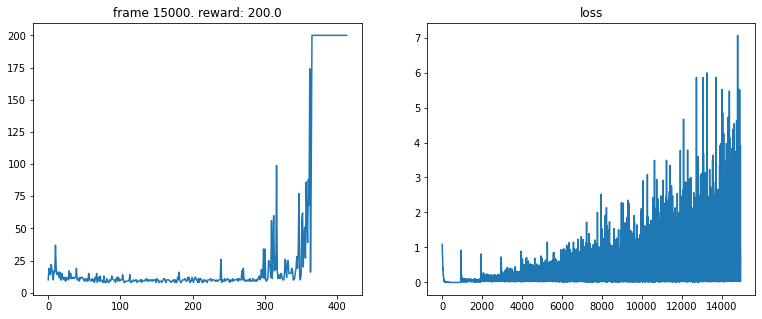

In [ ]:
for frame_idx in range(1, num_frames + 1):

    epsilon = epsilon_by_frame(frame_idx)
    
    # Step 6.1: Given the current state "state", sample an action from the Q network
    action = dqn_model.act(state, epsilon)
    
    # Step 6.2: Perform the previously sampled action on the environment, and
    # observe the next state and reward
    next_state, reward, done, _ =  env.step(action)
    next_state = basis_transform(next_state)
    # Step 6.3: Push the experience to the replay buffer. Already implemented
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        # Step 6.4: If the episode terminates, we reset the episode and episode_reward.
        # Already implemented
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        # Step 6.5: Only if we have enough examples in the replay buffer, we train the DQN
        # Already implemented
        loss = compute_td_loss(batch_size, device, dqn_model, target_model)
        losses.append(loss.item())
        
    if frame_idx % 200 == 0:
        # Step 6.6: Plot the reward and loss every 200 episode
        # The environment is considered solved when the reward per episode is consistantly >= 190
        # Already implemented
        plot(frame_idx, all_rewards, losses)
        
    if frame_idx % 1000 == 0:
        # Step 6.7: Copy the parameters of the DQN to the Target network after every 100 episodes
        # Already implemented
        target_model.load_state_dict(dqn_model.state_dict())

In [ ]:
# After successfully training the DQN, Run to below code to view the agent's permormance
# Already implemented 
env = gym.make('CartPole-v0')
env = wrap_env(env)

frame = env.reset()

is_done = False
counter = 0
tot_reward = 0
while not is_done:
  with torch.no_grad():
    inpt = torch.tensor(frame).float().unsqueeze(0).to(device)
    action = dqn_model(inpt).squeeze().argmax().item()
    frame, reward, is_done, _ = env.step(action)
    counter += 1
    tot_reward += reward

env.close()
show_video()